I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_file = '/u/ki/swmclau2/des/wt_trainer/PearceRedMagicChinchillaWT.hdf5'

em_method = 'gp'
split_method = 'random'

In [4]:
a = 0.81120
z = 1.0/a - 1.0


In [5]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [7]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params, independent_variable=None)

ValueError: need at least one array to concatenate

In [ ]:
emu._ordered_params

In [ ]:
print emu.y

In [ ]:
params = {}
#params['mean_occupation_centrals_assembias_param1'] = 0
#params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 11.95
params['sigma_logM'] = 0.2
params['f_c'] = 0.2
params['alpha'] = 1.21
params['logM1'] = 13.71
params['logM0'] = 11.39

print params

In [ ]:
emu.x[0,:-1]

In [ ]:
emu._ordered_params.items()

In [ ]:
for k,v in params.iteritems():
    print k,'\t'*5,v

In [ ]:
zbin = 1
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

In [ ]:
wt = emu.emulate_wrt_r(params, emu.scale_bin_centers)[0]
plt.plot(emu.scale_bin_centers, wt, label = 'Emu')
l = len(emu.scale_bin_centers)
#plt.plot(emu.scale_bin_centers, emu.y[(idx)*l:(idx+1)*l]+emu.y_hat, label = 'Training')
plt.plot(emu.scale_bin_centers, wt_redmagic, label = 'RedMagic')
plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.xscale('log')
plt.legend(loc='best')

In [ ]:
plt.plot(emu.scale_bin_centers, wt/wt_redmagic)
plt.xscale('log')

In [ ]:
print wt

In [ ]:
from pearce.mocks import compute_prim_haloprop_bins, cat_dict

In [ ]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [20]:
cat.load_model(a, 'hsabRedMagic')

In [22]:
binno = 1
binlen = len(emu.scale_bin_centers)
params = {pname:val for pname, val in zip(emu._ordered_params.iterkeys(), emu.x[binno*binlen,:-1])}
cat.populate(params)

In [29]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [43]:
rbins = [0.31622777, 0.44326829, 0.62134575, 0.87096359, 1.22086225, 1.7113283, 2.39883292, 3.36253386, 4.71338954, 6.60693448, 9.26118728,  12.98175275, 18.19700859,  25.50742784,  35.75471605,  50.11872336]

In [89]:
params['mean_occupation_centrals_assembias_param1'] = 0.0
params['mean_occupation_satellites_assembias_param1'] = 0
params['logMmin'] = 12.3
params['sigma_logM'] = 0.28
params['f_c'] = 0.2
params['alpha'] = 1.01
params['logM1'] = 13.71
params['logM0'] = 11.39

In [90]:
redmagic_nd = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_nd_11.npy')
print redmagic_nd

0.00029835237080432165


In [91]:
redmagic_wt = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_11.npy')
print redmagic_wt

[0.45695747 0.36215491 0.29041139 0.23118318 0.19100328 0.151003
 0.13108268 0.10749353 0.08680055 0.07528302 0.06291195 0.05189149
 0.04115488 0.0302334  0.02223498 0.015794   0.01055951 0.0067024
 0.00453897 0.00266568]


0.00026702924306740844


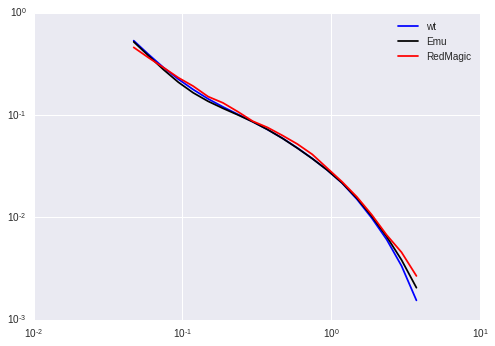

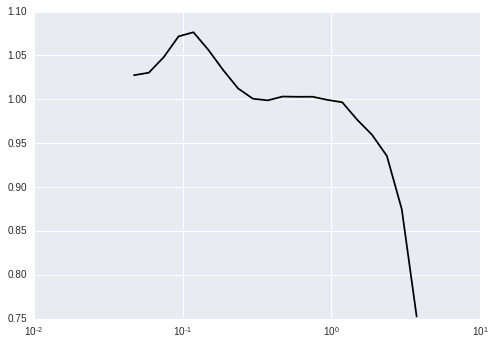

In [92]:
cat.populate(params)
wt = cat.calc_wt(theta_bins,rbins, W= 0.00275848072207, n_cores=1)
print cat.calc_analytic_nd(params)

plt.plot(emu.scale_bin_centers,wt, label = 'wt' , color = 'b')
plt.plot(emu.scale_bin_centers, emu.emulate_wrt_r(params,emu.scale_bin_centers)[0] ,label = 'Emu')
plt.plot(emu.scale_bin_centers, wt_redmagic, label = 'RedMagic', color = 'r')
plt.legend(loc='best')
plt.loglog()
plt.show()
#plt.plot(emu.scale_bin_centers,wt)
plt.plot(emu.scale_bin_centers, wt/emu.emulate_wrt_r(params,emu.scale_bin_centers)[0])
plt.xscale('log')
plt.show()
#plt.loglog()
#plt.xlim([2.25/60, 275/60])
#plt.ylim([0.8, 4.0])

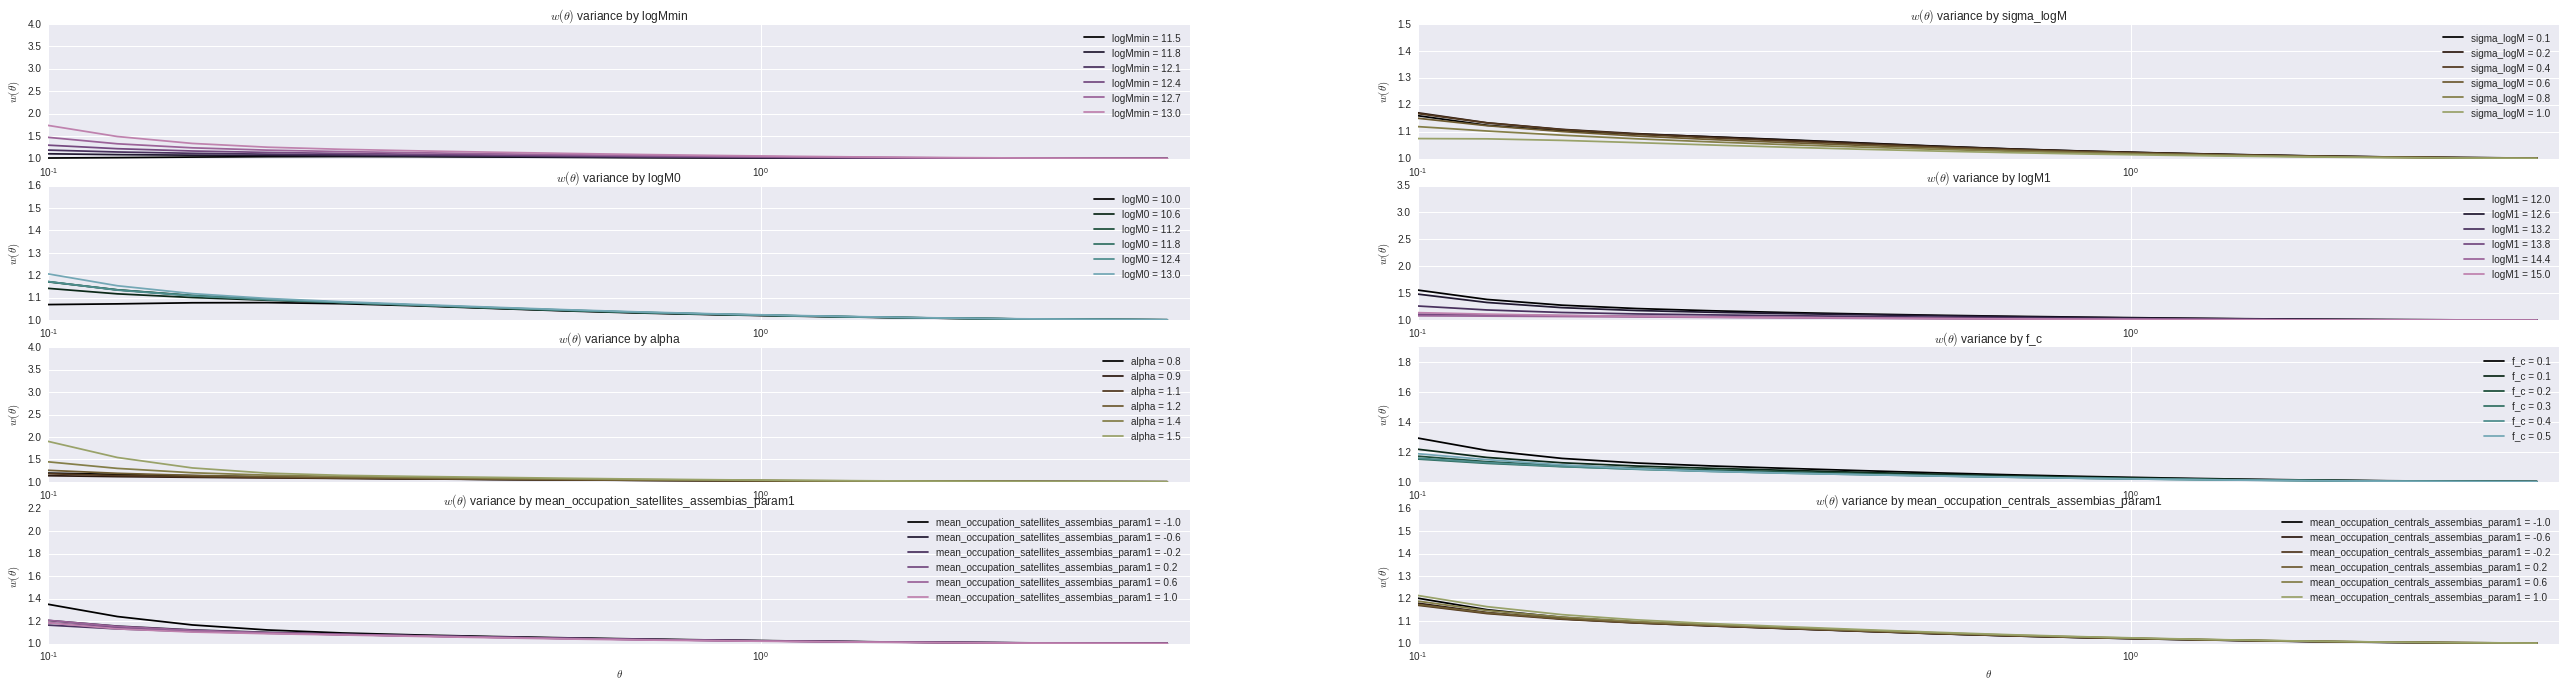

In [25]:
fig = plt.figure(figsize=(45,14))


emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.333),
                    ('alpha', 1.053),('logM1', 13.5), ('logMmin', 12.033)]

em_params = dict(emulation_point)

em_params.update(fixed_params)
del em_params['z']

fixed_params2 = {'mean_occupation_satellites_assembias_param1':0.0,
                'mean_occupation_centrals_assembias_param1':0.0}

for idx, (param, bounds) in enumerate(emu._ordered_params.iteritems()):
    if param == 'r':
        continue
    wt_vals = []
    new_em_params = {}
    new_em_params.update(em_params)
    new_em_params.update(fixed_params2)
    for v in np.linspace(bounds[0], bounds[1], 6):
        new_em_params[param] = v
        wt_vals.append(emu.emulate_wrt_r(new_em_params, tpoints))
    wt_vals = np.array(wt_vals)
    
    pal = sns.cubehelix_palette(wt_vals.shape[0], start=idx, rot=0.3,\
                            dark=0.0, light=.60,reverse = True)
    #sns.palplot(pal)

    sns.set_palette(pal)

    #sns.set_style("darkgrid", {"axes.facecolor": "0.85"})
    plt.subplot(5,2,idx+1)

    for color, wt, v in zip(pal, wt_vals,np.linspace(bounds[0], bounds[1], 6) ):
        plt.plot(tpoints, 1+wt[0,:], color = color, label = r'%s = %.1f'%(param,v) )
    #plt.loglog()
    plt.xscale('log')
    plt.legend(loc='best')
    plt.xlim([0.1, 4])
    plt.title(r'$w(\theta)$ variance by %s'%param)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$w(\theta)$')
plt.show()